# Black-Scholes Model

https://www.investopedia.com/terms/b/blackscholes.asp

## Importing important libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import date

import warnings
warnings.filterwarnings("ignore")

# to fetch data 
import yfinance as yf

import scipy.stats as ss

## Importing data

In [2]:
symbol = 'AAPL'
end = date.today()
start = end.replace(year = 2020)

tickerData = yf.Ticker(symbol)

# Read data 
df = tickerData.history(period='1d', start=start, end=end, interval = '1d')


df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-07-14,148.100006,149.570007,147.679993,149.149994,127050800,0.0,0.0
2021-07-15,149.240005,150.000000,147.089996,148.479996,106820300,0.0,0.0
2021-07-16,148.460007,149.759995,145.880005,146.389999,93100300,0.0,0.0
2021-07-19,143.750000,144.070007,141.669998,142.449997,121434600,0.0,0.0
2021-07-20,143.460007,147.100006,142.960007,146.149994,96238600,0.0,0.0


In [3]:
symbol = 'AAPL'  #the ticker of the stock whose data is to be taken out
dfo = yf.Ticker(symbol)

In [4]:
dfo.options  #to get the date of different expiration time

('2021-07-23',
 '2021-07-30',
 '2021-08-06',
 '2021-08-13',
 '2021-08-20',
 '2021-08-27',
 '2021-09-17',
 '2021-10-15',
 '2021-11-19',
 '2021-12-17',
 '2022-01-21',
 '2022-03-18',
 '2022-06-17',
 '2022-09-16',
 '2023-01-20',
 '2023-03-17',
 '2023-06-16',
 '2023-09-15')

In [5]:
dfo_exp = dfo.option_chain(dfo.options[1])  #you can change index to try on different expiry dates

In [6]:
dfo_exp.calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL210730C00065000,2021-07-21 14:32:39,65.0,80.55,80.15,80.25,1.950005,2.480922,2,21,1.765626,True,REGULAR,USD
1,AAPL210730C00070000,2021-07-21 14:32:39,70.0,75.15,75.15,75.25,3.120003,4.331532,16,42,1.609377,True,REGULAR,USD
2,AAPL210730C00075000,2021-07-21 15:27:22,75.0,70.85,70.20,70.30,-3.550003,-4.771509,21,2,1.468753,True,REGULAR,USD
3,AAPL210730C00080000,2021-07-21 13:53:05,80.0,65.40,65.20,65.30,0.340004,0.522601,1,70,1.328128,True,REGULAR,USD
4,AAPL210730C00085000,2021-07-21 14:18:42,85.0,60.80,60.20,60.30,0.649998,1.080628,19,144,1.203129,True,REGULAR,USD


## Calculation of annual volatility

Annual volatility of the stock can be calculated as:<br/>
Calculating daily logarithmic returns<br/>
Then calculating its standard deviation to get daily volatility<br/>
Then multiplying it by sqrt(252) as there are 252 trading days in a year.

In [7]:
def annual_vol(df):
    """
    Function to calculate annual volatility
    
    Parameters
    ----------
    df : dataframe
         Stock info

    Returns
    -------
    vol : float
        annual volatility of the stock
    """
    
    log_return = np.log(df['Close']) - np.log(df['Close'].shift(1))
    log_return = log_return[1:]  #to remove nan 
    daily_vol = log_return.std()
    vol = daily_vol*(252**0.5)
    
    return vol

In [8]:
vol = annual_vol(df)
vol

0.3442881370951705

## Black Scholes Model

\begin{equation*}
C=SN(d1)−Ke^{−rt}N(d2)\\
P=Ke^{−rt}N(-d2)-SN(-d1)
\end{equation*}

\begin{equation*}
d1 = (ln(S/K) + (r+σ^2/2)t)/σ\sqrt{t}\\
d2 = d1 - σ\sqrt{t}
\end{equation*}

C : call option price<br/>
P : Put option price<br/>
S : Stock price<br/>
K : Strike price<br/>
r : risk free rate<br/>
t : time of maturity in year<br/>
N = Normal distribution

In [9]:
def euro_vanilla(S, K, T, r, sigma, option = 'call'):
    """
    To calculate options price with the help of black-scholes model
    
    Parameters
    ----------
    S : float
        The price of the underlying
    
    K : float
        Strike price of the option
        
    T : float
        Time to expiry in years
        
    r : float
        Risk free rate which can be taken as the US Treasury bond yield
        
    sigma : float
        The annual volatility of the returns
        
    option : string
        call for call option
        put for put option
    
    Returns
    -------
    premium : float
        The price of call or put option
    """
    
    
    d1 = (np.log(S/K) + (r + sigma**2 / 2) * T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    if option == 'call':
        premium = S * ss.norm.cdf(d1) - K * np.exp(-r * T) * ss.norm.cdf(d2)
    if option == 'put':
        premium =  K * np.exp(-r * T) * ss.norm.cdf(-d2) - S * ss.norm.cdf(-d1)
        
    return premium

In [10]:
T = 9/365  #time to expiry
N = 100 
t = T/N

In [11]:
#r is the risk free rate taken from the 10 years us treasury bond
call = {}
for K in dfo_exp.calls['strike']:
    call_price = euro_vanilla(S = df['Close'][len(df)-1], K = K, T = T, r=0.0123*t, sigma=vol)
  # print(call_price)
    call[K] = call_price
th_call = pd.DataFrame.from_dict(call, orient='index')
th_call.rename(columns = {0:"th_call"}, inplace = True)
th_call.head()

,th_call
65.0,81.149999
70.0,76.149999
75.0,71.150000
80.0,66.150000
85.0,61.150000


In [12]:
ac_call = dfo_exp.calls.loc[:, ['strike', 'lastPrice']]
ac_call.set_index('strike', inplace = True)
ac_call.rename(columns = {"lastPrice":"ac_call"}, inplace=True)
ac_call.head()

,ac_call
strike,
65.0,80.55
70.0,75.15
75.0,70.85
80.0,65.40
85.0,60.80


In [13]:
call = th_call
call["ac_call"] = ac_call
call.head(10)

,th_call,ac_call
65.0,81.149999,80.55
70.0,76.149999,75.15
75.0,71.150000,70.85
80.0,66.150000,65.40
85.0,61.150000,60.80
90.0,56.150001,52.90
95.0,51.150001,48.53
100.0,46.150001,45.32
105.0,41.150002,40.35
110.0,36.150002,35.32


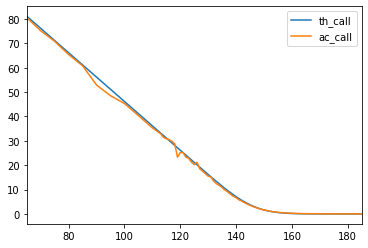

In [14]:
call.plot()

In [15]:
#r is the risk free rate taken from the 10 years us treasury bond
put = {}
for K in dfo_exp.puts['strike']:
    put_price = euro_vanilla(S = df['Close'][len(df)-1], K = K, T = T, r=0.0158*t, sigma=vol, option = 'put')
  # print(put_price)
    put[K] = put_price
th_put = pd.DataFrame.from_dict(put, orient='index')
th_put.rename(columns = {0:"th_put"}, inplace = True)
th_put.head()

,th_put
65.0,1.551133e-51
70.0,6.354096e-43
75.0,1.244654e-35
80.0,1.922797e-29
85.0,3.485184e-24


In [16]:
ac_put = dfo_exp.puts.loc[:, ['strike', 'lastPrice']]
ac_put.set_index('strike', inplace = True)
ac_put.rename(columns = {"lastPrice":"ac_put"}, inplace=True)
ac_put.head()

,ac_put
strike,
65.0,0.01
70.0,0.01
75.0,0.01
80.0,0.01
85.0,0.01


In [17]:
put = th_put
put["ac_put"] = ac_put
put.tail(10)

,th_put,ac_put
157.5,11.661819,12.75
160.0,14.010697,15.15
162.5,16.428345,17.45
165.0,18.886160,19.80
167.5,21.365814,22.25
170.0,23.856559,24.43
172.5,26.352581,27.15
175.0,28.850962,29.60
180.0,33.850108,36.50
185.0,38.850000,40.05


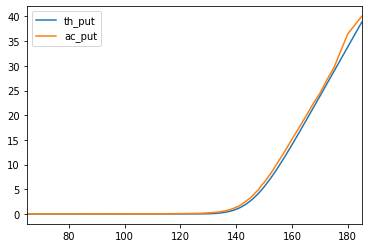

In [18]:
put.plot()

## Put-call Parity


\begin{equation*}
C + PV(K) = P + S
\end{equation*}


C = price of the European call option <br/>
PV(K) = the present value of the strike price (K), discounted from the value on the expiration date at the risk-free rate <br/>
P = price of the European put<br/>
S = spot price or the current market value of the underlying asset

In [19]:
data = pd.concat([call, put], axis=1)

In [20]:
data

,th_call,ac_call,th_put,ac_put
65.0,81.149999,80.55,1.551133e-51,0.01
70.0,76.149999,75.15,6.354096e-43,0.01
75.0,71.150000,70.85,1.244654e-35,0.01
80.0,66.150000,65.40,1.922797e-29,0.01
85.0,61.150000,60.80,3.485184e-24,0.01
90.0,56.150001,52.90,1.020613e-19,0.02
95.0,51.150001,48.53,6.268817e-16,0.01
100.0,46.150001,45.32,1.001810e-12,0.02
105.0,41.150002,40.35,4.986852e-10,0.02
110.0,36.150002,35.32,9.002335e-08,0.02


In [21]:
data.dropna(inplace = True)
data.head()

,th_call,ac_call,th_put,ac_put
65.0,81.149999,80.55,1.551133e-51,0.01
70.0,76.149999,75.15,6.354096e-43,0.01
75.0,71.150000,70.85,1.244654e-35,0.01
80.0,66.150000,65.40,1.922797e-29,0.01
85.0,61.150000,60.80,3.485184e-24,0.01


In [22]:
data["PV(K)"] = data.index
data["PV(K)"] = data["PV(K)"]*np.exp(-0.0158*t)

In [23]:
data["Spot Price"] = df["Close"][len(df)-1]
data.head()

,th_call,ac_call,th_put,ac_put,PV(K),Spot Price
65.0,81.149999,80.55,1.551133e-51,0.01,64.999747,146.149994
70.0,76.149999,75.15,6.354096e-43,0.01,69.999727,146.149994
75.0,71.150000,70.85,1.244654e-35,0.01,74.999708,146.149994
80.0,66.150000,65.40,1.922797e-29,0.01,79.999688,146.149994
85.0,61.150000,60.80,3.485184e-24,0.01,84.999669,146.149994


In [24]:
put_call_parity = data["th_call"] - data["th_put"] - data["Spot Price"] + data["PV(K)"]

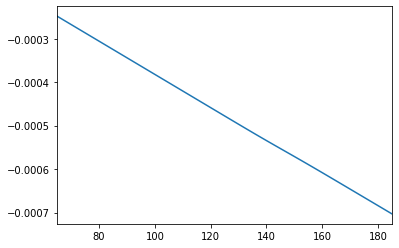

In [25]:
put_call_parity.plot()

In [26]:
put_call_parity = data["ac_call"] - data["ac_put"] - data["Spot Price"] + data["PV(K)"]

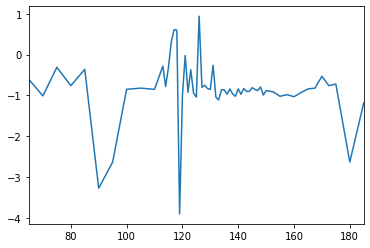

In [27]:
put_call_parity.plot()

The put-call parity in the actual market may not hold good because of the difference in supply and demand thus opening up the arbitrage opportunity for the traders. But this oppportunity is for very low time and mostly occurs in less volume options, i.e., deep in the money or deep out of money options.